## ***Proyecto meteoritos***

![picture](https://media.istockphoto.com/photos/comet-an-asteroid-a-meteorite-glows-enters-the-earths-atmosphere-of-picture-id1073058680?k=20&m=1073058680&s=612x612&w=0&h=EDruZyNBx6TYKOUmWKq57pyEgDj8-9qAl2wN24If040=)

Un meteorito es un objeto natural proviente del espacio interplanetario, que logra sobrevivir su paso por la atmósfera terrestre y aterriza en su superficie. El meteorito más grande identificado en la Tierra se denominó Hoba y fue encontrado en Namibia en 1920. Tiene unos 2.7 metros de diámetro y su masa es de aproximadamente 60 toneladas, cuya composición es principalmente hierro y níquel. Los meteoritos más pequeños, los micrometeoritos, se miden en la escala de los micrómetros y generalmente provienen de partículas de polvo interplanetario

Objetivos

*   Analizar la distribución geográfica de los meteoritos entre los años 1800 y 2013.
*   Estimar el promedio de la masa de los meteoritos por año y comparar estos promedios en los años 1980 a 2010
*   Explorar la ubicación geográfica de los meteoritos con mayor masa en los años estudiados
*   Derivar una clasificación más general de los meteoritos a partir de los datos y comparar sus frecuencias





In [ ]:
# Librería de datos geoespaciales GeoPandas.
!pip install -U geopandas 
!pip install -U rtree mapclassify fiona pyproj
!sudo apt install libspatialindex-dev

*Importamos las librerías correspondientes*

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd   
from shapely.geometry import *

Cargamos el dataset "meteorite-landings" en formato csv, tomado de la página https://www.kaggle.com/datasets/nasa/meteorite-landings

In [16]:
meteorite = pd.read_csv('meteorite-landings.csv')
meteorite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


Exploremos los datos

In [17]:
meteorite.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


| Variable | Definición	| Valores | 
| --- | --- | --- |
| name | 	Nombre del meteorito  ||
| id | 	Identificación del meteorito  ||
| nametype | Validez de la identificación  |Valid, Relict|
| reclass 	| Tipo de meteorito | |
| mass 	|Masa en gramos 	| |
| fall |	Si el meteorito se observó o no al caer 	|Fell, Found |
| year |	Año 	| |
| reclat |	Latitud 	| |
| reclong |	Longitud	| |
| GeoLocation |	Tupla (Latitud, Longitud) | |

Eliminamos las columnas 'id' y 'nametype' del dataset, las cuales no tienen información relevante

In [18]:
meteorite.drop(columns = ['id', 'nametype'], inplace = True)

Limpiamos el dataset primero limitando los años al período 1800 a 2016 y filtramos las coordenadas que no corresponden con valores apropiados, y finalmente eliminamos los valores con coordenadas 0,0

In [19]:
meteorite.drop(meteorite.index[meteorite['reclong'] > 180], inplace=True)
meteorite.drop(meteorite.index[meteorite['GeoLocation'] == (0, 0)], inplace=True) #Filtramos valores en cero
meteorite.drop(meteorite.index[meteorite['year'] > 2016], inplace=True) #Limitamos los años al intervalo 1800 - 2016
meteorite.drop(meteorite.index[meteorite['year'] < 1800], inplace=True)

## **Meteoritos por año**

Graficamos un histograma con la cantidad de meteoritos registrada entre los años 1970 y 2016, distinguiendo entre Fell (vistos durante la caída) y Found (encontrados posteriormente a su caída)

(1970.0, 2016.0)

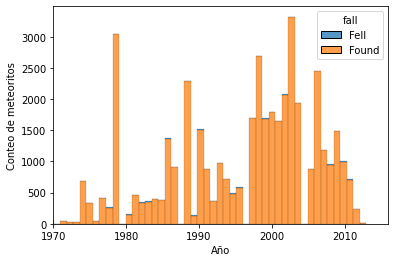

In [20]:
plot1 = sns.histplot(data= meteorite, x = 'year', kde=False, hue = 'fall', multiple="stack")
plot1.set_xlabel('Año')
plot1.set_ylabel('Conteo de meteoritos')
plot1.set_xlim(1970,2016)

## **Masa de los meteoritos**

Calculamos la masa promedio de los meteoritos, eliminamos los elementos nulos y aquellos que tienen masa igual a cero

In [21]:
mass_meteorite = meteorite.dropna(subset = ['mass'])
mass_meteorite = meteorite[meteorite['mass'] != 0]
mean_mass = mass_meteorite['mass'].mean()

mean_mass

11725.404636465495

Distribución de los 20 meteoritos más grandes que se han encontrado a partir de 1800. Primero seleccionamos los meteoritos más grandes:

In [ ]:
bigger = mass_meteorite.sort_values(by = ['mass'], ascending=False)
bigger.head(20)

Text(0.5, 1.0, 'Meteoritos más grandes')

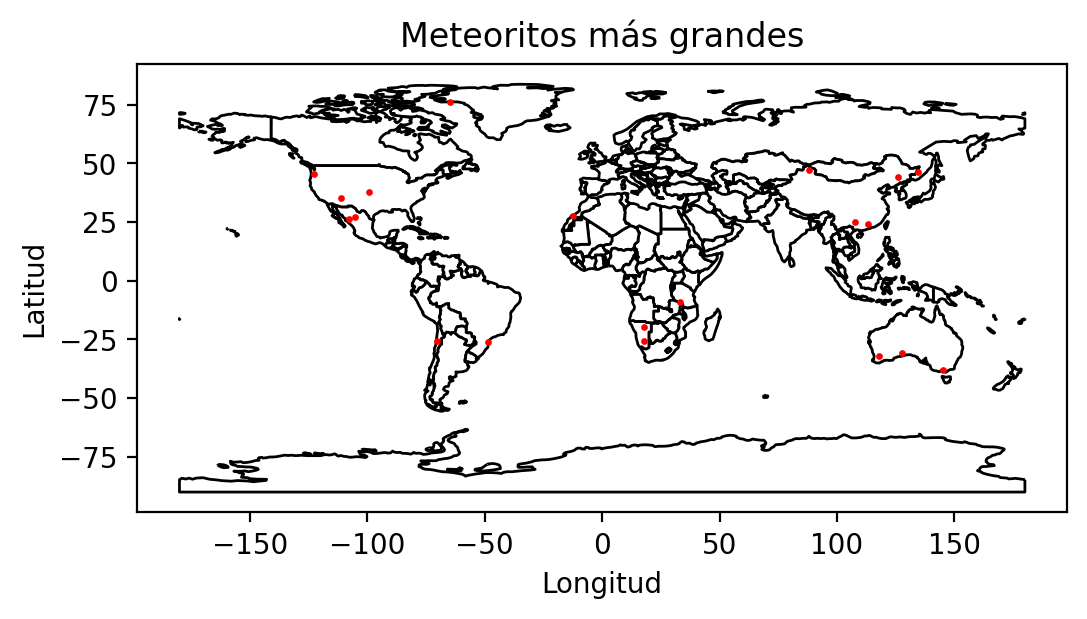

In [23]:
geometry=[Point(xy) for xy in zip(bigger['reclong'].head(20), bigger['reclat'].head(20))]
geodata=gpd.GeoDataFrame(bigger.head(20), geometry=geometry)
path = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(path)
fig, ax = plt.subplots(dpi = 200)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize=10)
world.plot(ax=ax, color='white', edgecolor='black')
geodata.plot(ax=ax, markersize=2, color = 'red')
plt.title('Meteoritos más grandes')


Masa promedio de los meteoritos por año:

In [ ]:
mean_mass = mass_meteorite.groupby(['year'])['mass'].mean()
mean_mass.index = mean_mass.index.astype('int64')
mean_mass.loc['1980':'2011']

Deseamos establecer si la masa promedio de los meteoritos varió significativamente entre los años 1980 y 2010, para ello realizamos una gráfica de dispersión:

(700.0, 10000.0)

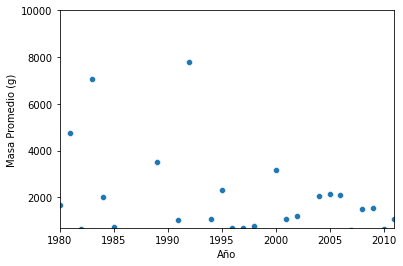

In [25]:
plot2 = sns.scatterplot(data = mean_mass.to_frame(), x = 'year', y = 'mass')
plot2.set_xlabel('Año')
plot2.set_ylabel('Masa Promedio (g)')
plot2.set_xlim(1980,2011)
plot2.set_ylim(700,10000)


Observamos que los años 1981, 1983 y 1992 se hallaron los meteoritos con mayor masa

# **Clasificación de los meteoritos**

El dataset contiene una clasificación del objeto en la columna 'recclass', sin embargo hay demasiadas categorías. Indagando en Internet encontramos una clasificación más general de los meteoritos y procedemos a generar menos categorías para agruparlos.

In [ ]:
meteorite['recclass'].unique() #Demasiadas categorías

Primero definimos una abreviatura para cada grupo en la clasificación

In [27]:
Classes_names = {'PA':'Primitive Achondrites', 'OC': 'Ordinary Chondrites', 'CC': 'Carbonaceous Chondrites', 
'EC': 'Enstatite Chondrites', 'IA': 'Iron Achondrites', 'Lunar' : 'Planetary Lunar', 'Mars' : 'Planetary Martian', 'OT': 'Other Chondrites', 
'Pall':'Pallasites Achondrites', 'VA': 'Vestan Achondrites' }

Posteriormente definimos una función que añada una nueva columna con la clasificación propuesta

In [28]:
def clasificacion (series):
    new_col = []
    for item in series:
        if item[:2] == 'Ac' or item[:2]== 'Ur' or item[:2]=='IA' or item[:2]=='Bra' or item[:2]=='Lo':
            new_col.append('PA')
        elif item[:2] == 'Lu':
            new_col.append('Lunar')
        elif item[0] == 'H' or item[0] == 'L':
            new_col.append('OC')
        elif item[0] == 'C':
            new_col.append('CC')
        elif item[0] == 'E' and item[:2] != 'Eu':
            new_col.append('EC')
        elif item[0] == 'I':
            new_col.append('IA')
        elif item[:2] == 'Ma':
            new_col.append('Mars')
        elif item[0] =='R' or item[0] == 'K' and item[:2] != 'Re':
            new_col.append('OT')
        elif item[0] == 'P':
            new_col.append('Pall')
        elif item[:2] == 'Eu' or item[:2] == 'Di' or item[:2] == 'Ho':
            new_col.append('VA')
        else:
            new_col.append('Other')
    return new_col

Generamos la nueva columna 'newclass' en el dataset y observamos el resultado

In [ ]:
meteorite['newclass'] = clasificacion(meteorite['recclass'])
meteorite.head(20)

En el siguiente histograma observamos que la gran mayoría de los meteoritos son Condritas comunes (OC):

Text(0, 0.5, 'Conteo de meteoritos')

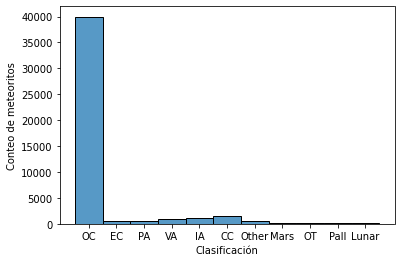

In [30]:
plot3 = sns.histplot(data= meteorite, x = 'newclass', kde=False)
plot3.set_xlabel('Clasificación')
plot3.set_ylabel('Conteo de meteoritos')

Para visualizar mejor la distribución de las demás clases de meteoritos, eliminamos los datos de condritas comunes y realizamos el histrograma nuevamente:

Text(0, 0.5, 'Conteo de meteoritos')

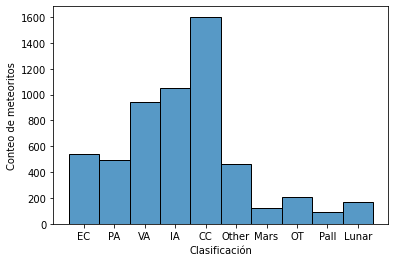

In [31]:
no_ordinary = meteorite[meteorite['newclass'] != 'OC']
plot4 = sns.histplot(data= no_ordinary, x = 'newclass', kde=False)
plot4.set_xlabel('Clasificación')
plot4.set_ylabel('Conteo de meteoritos')

Analicemos la distribución geográfica de los meteoritos no comunes (condritas ordinarias) según su clasificación:

Text(0.5, 1.0, 'Distribución de los Meteoritos según su clasificación')

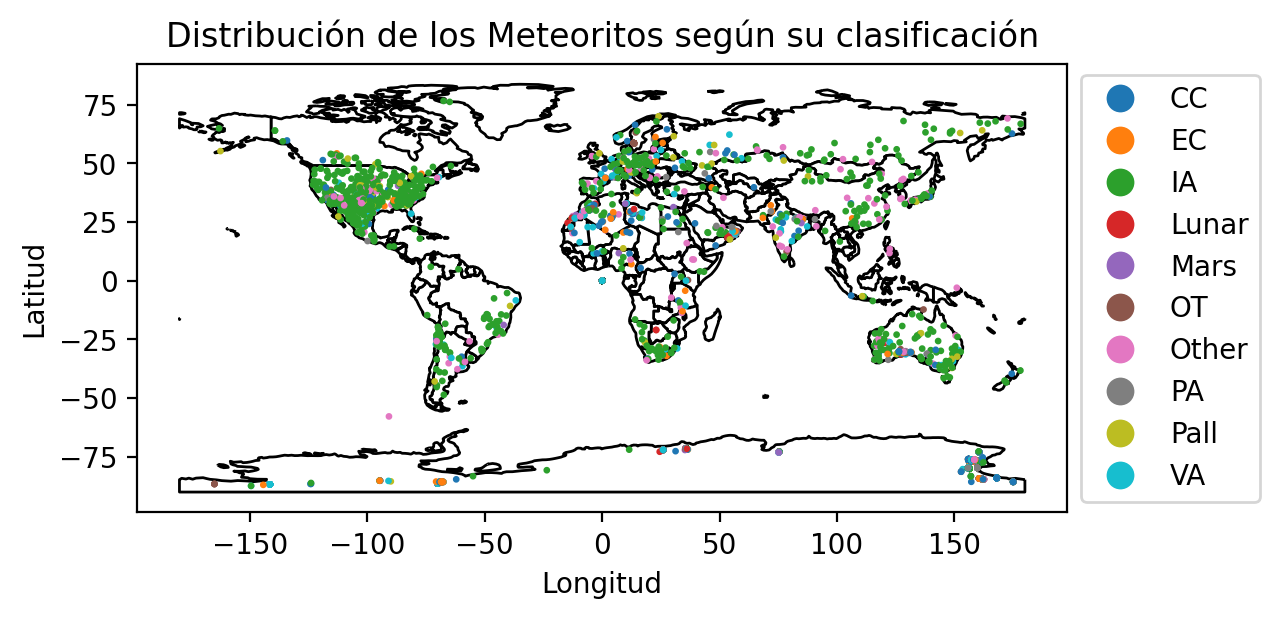

In [32]:
geometry1=[Point(xy) for xy in zip(no_ordinary['reclong'], no_ordinary['reclat'])]
geodata=gpd.GeoDataFrame(no_ordinary, geometry=geometry1)

path = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(path)

fig, ax = plt.subplots(dpi = 200)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize=10)
world.plot(ax=ax, color='white', edgecolor='black')
geodata.plot(column = 'newclass', ax=ax, markersize=2, legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
plt.title('Distribución de los Meteoritos según su clasificación')

## **Distribución de los meteoritos en la Tierra**

Veamos como se distribuyen los meteoritos de acuerdo con su manera de recolección: 'Fell' o 'Found':

Text(0.5, 1.0, 'Meteoritos')

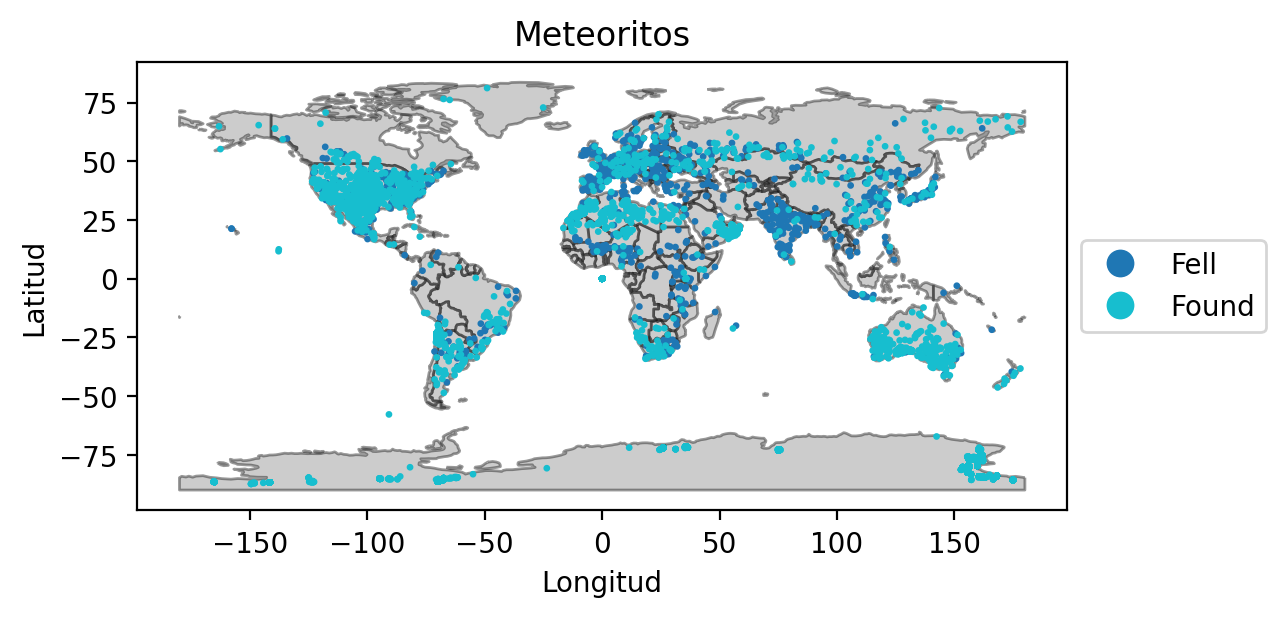

In [33]:
geometry2=[Point(xy) for xy in zip(meteorite['reclong'], meteorite['reclat'])]
geodata=gpd.GeoDataFrame(meteorite, geometry=geometry2)

path = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(path)

fig, ax = plt.subplots(dpi = 200)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize=10)
world.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geodata.plot(column = 'fall', ax=ax, markersize=2, legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
plt.title('Meteoritos')
